### Basic imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-darkgrid")

In [2]:
df = pd.read_excel('Comment Spam.xls', index_col='No')
df.head()

,Comment,Class
No,,
1,this song is racist,0
2,and how many subscribers compared to her over ...,1
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
4,well done shakira,0
5,:D subscribe to me for daily vines,1


### EDA

### Finding null rows

In [3]:
df.isnull().sum()

Comment    0
Class      0
dtype: int64

In [4]:
df['Class'].value_counts()

1    669
0    631
Name: Class, dtype: int64

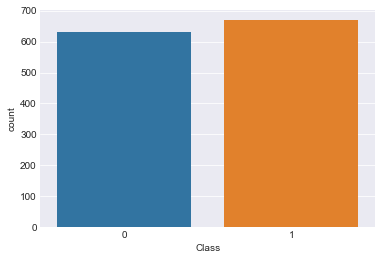

In [5]:
sns.countplot(df['Class'])

In [6]:
df['Length'] = df['Comment'].apply(len)

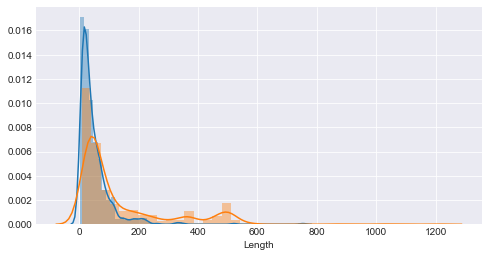

In [7]:
plt.figure(figsize=(8,4))
sns.distplot(df[df['Class'] == 0]['Length'])
sns.distplot(df[df['Class'] == 1]['Length'])

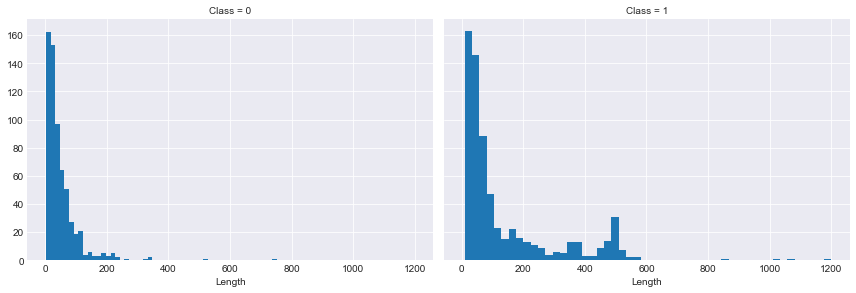

In [8]:
g = sns.FacetGrid(df, col="Class", height=4, aspect=1.5)
g.map_dataframe(plt.hist, x="Length", bins=50)
g.set_axis_labels("Length")

#### From here we can conclude that the length of the text is not a very distinctive feature

### Imports for cleaning & formatting data

In [9]:
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
def text_cleaner(text):
    """
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming
    """
    
    text = re.sub("[^A-Za-z]", " ", text)
    text = text.lower()
    text = word_tokenize(text)
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    text = " ".join(text)
    return text

### Cleaning & formatting data

In [11]:
df['Clean Comment'] = df['Comment'].apply(text_cleaner)

In [12]:
df

,Comment,Class,Length,Clean Comment
No,,,,
1,this song is racist,0,19,song racist
2,and how many subscribers compared to her over ...,1,55,mani subscrib compar million
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1,57,hi check awesom cover say think
4,well done shakira,0,17,well done shakira
5,:D subscribe to me for daily vines,1,34,subscrib daili vine
...,...,...,...,...
1296,Awsome<br />﻿,0,13,awsom br
1297,https://www.tsu.co/KodysMan plz ^^﻿,1,35,http www tsu co kodysman plz
1298,Sign up for free on TSU and start making money...,1,129,sign free tsu start make money social media ad...


### Find the most frequent Non-Spam Words

In [13]:
from collections import Counter

words = df[df['Class']==0]['Clean Comment'].apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)

In [14]:
pd.DataFrame.from_dict(ham_words, orient='index').reset_index().rename(columns={'index':'word',0: "count"}).sort_values(by='count', ascending=False)

,word,count
0,song,155
21,love,106
29,view,73
44,like,67
88,video,59
...,...,...
529,choic,1
528,terror,1
170,date,1
526,babe,1


### Find the most frequent Spam Words

In [15]:
from collections import Counter

words = df[df['Class']==1]['Clean Comment'].apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)

In [16]:
pd.DataFrame.from_dict(spam_words, orient='index').reset_index().rename(columns={'index':'word',0: "count"}).sort_values(by='count', ascending=False)

,word,count
5,check,416
43,video,212
57,com,200
1,subscrib,175
123,pleas,172
...,...,...
1112,readi,1
1110,retriev,1
1109,anxiou,1
1108,set,1


### Splitting data

In [17]:
X = df['Clean Comment']
y = df['Class']

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Vectorizing Data (Creating BOW)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

### Transform to TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_vec = tfidf_transformer.fit_transform(X_train_vec)
X_test_vec = tfidf_transformer.transform(X_test_vec)

## Model Exploration

### Multinomial Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
modelNB = MultinomialNB()

In [23]:
modelNB.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
y_pred = modelNB.predict(X_test_vec)

In [25]:
from sklearn import metrics

In [26]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test, y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


              precision    recall  f1-score   support

           0       0.95      0.85      0.90       198
           1       0.86      0.95      0.91       192

    accuracy                           0.90       390
   macro avg       0.91      0.90      0.90       390
weighted avg       0.91      0.90      0.90       390



In [27]:
print(y_test.shape)
print(y_pred.shape)

(390,)
(390,)


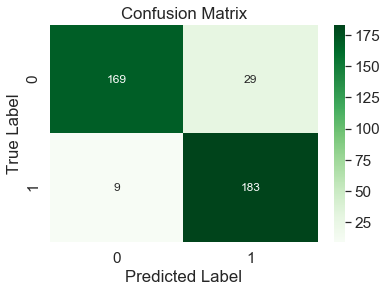

In [28]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
y_pred_proba = modelNB.predict_proba(X_test_vec)[:,1]
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC - AUC Score is: {roc_auc_score}')

ROC - AUC Score is: 0.9801004840067341


In [30]:
nbAcc = metrics.accuracy_score(y_test, y_pred)

### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [32]:
logreg.fit(X_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred_logreg = logreg.predict(X_test_vec)

In [34]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test, y_pred_logreg))
print('=======================================================')

=================CLASSIFICATION REPORT=================


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       198
           1       0.96      0.92      0.94       192

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



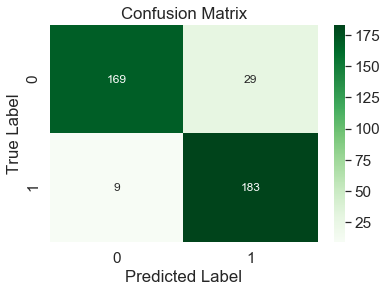

In [35]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [36]:
y_pred_proba = logreg.predict_proba(X_test_vec)[:,1]
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC - AUC Score is: {roc_auc_score}')

ROC - AUC Score is: 0.9884127735690236


In [37]:
lrAcc = metrics.accuracy_score(y_test, y_pred)

### Let's try Using other models using a Pipeline

#### First we need to redefine our text cleaner to it will return words and set is as the analyzer for our Bag of Words.

In [38]:
def text_cleaner_pipe(text):
    """
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming
    """
    
    text = re.sub("[^A-Za-z]", " ", text)
    text = text.lower()
    text = word_tokenize(text)
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    return text

### Decision Tree

In [39]:
from sklearn.pipeline import Pipeline

In [40]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7f8bfd383b90>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_

In [41]:
y_pred = pipe.predict(X_test)

In [42]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


              precision    recall  f1-score   support

           0       0.93      0.96      0.94       198
           1       0.96      0.92      0.94       192

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



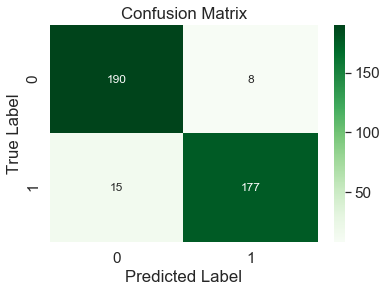

In [43]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
y_pred_proba = pipe.predict_proba(X_test)[:,1]
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC - AUC Score is: {roc_auc_score}')

ROC - AUC Score is: 0.9454045664983166


In [45]:
dtAcc = metrics.accuracy_score(y_test, y_pred)

### Support Vector Machine

In [46]:
from sklearn.svm import SVC

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', SVC(probability=True))])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7f8bfd383b90>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                                 tokenizer=None, vocabulary=None)),
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, deci

In [47]:
y_pred = pipe.predict(X_test)

In [48]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


              precision    recall  f1-score   support

           0       0.92      0.97      0.95       198
           1       0.97      0.92      0.94       192

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



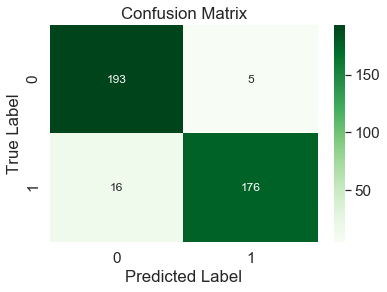

In [49]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
y_pred_proba = pipe.predict_proba(X_test)[:,1]
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC - AUC Score is: {roc_auc_score}')

ROC - AUC Score is: 0.9853219696969697


In [51]:
svmAcc = metrics.accuracy_score(y_test, y_pred)

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', RandomForestClassifier(random_state=42))])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7f8bfd383b90>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [53]:
y_pred = pipe.predict(X_test)

In [54]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       198
           1       0.98      0.94      0.96       192

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



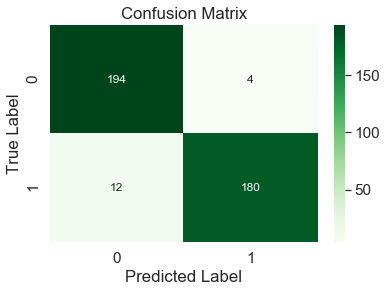

In [55]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [56]:
y_pred_proba = pipe.predict_proba(X_test)[:,1]
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC - AUC Score is: {roc_auc_score}')

ROC - AUC Score is: 0.98989898989899


In [57]:
rfAcc = metrics.accuracy_score(y_test, y_pred)

### Let's Make a Dataframe with the scores of each models

In [58]:
pd.DataFrame([['MultinomialNB',nbAcc], ['Logistic Regression',lrAcc], ['Decision Tree',dtAcc], ['SVM',svmAcc], ['Random Forest',rfAcc]], columns=['Model','Score']).sort_values('Score', ascending=False)

,Model,Score
4,Random Forest,0.958974
3,SVM,0.946154
2,Decision Tree,0.941026
0,MultinomialNB,0.902564
1,Logistic Regression,0.902564


#### From here we can conclude that the Random Forest has the highest accuracy score. We can then hypertune the model and let's see if we can still improve the performance.

### Hyperparameter Tuning Random Forest

In [59]:
from sklearn.model_selection import GridSearchCV


param_grid = {
                "criterion"         : ["gini"],
                "max_features"      : ['auto'],
                "n_estimators"      : [200, 400,1800, 2000],
                "bootstrap"         : [True,False],
                "min_samples_split" : [2, 5, 10],
                "min_samples_split" : [2,3,4],
                "max_depth"         : [10, 20, 90, 100, None],
                "min_samples_split" : [2,3,4]
              }


grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_test_vec, y_test)
print(grid_search.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 90, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 1800}


In [60]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', grid_search.best_estimator_)])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7f8bfd383b90>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=90, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0

In [61]:
y_pred = pipe.predict(X_test)

In [62]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       198
           1       0.98      0.94      0.96       192

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



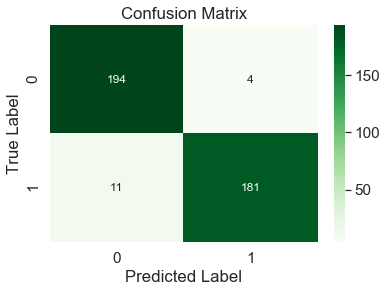

In [63]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [64]:
y_pred_proba = pipe.predict_proba(X_test)[:,1]
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC - AUC Score is: {roc_auc_score}')

ROC - AUC Score is: 0.9871896043771043


In [65]:
rf2Acc = metrics.accuracy_score(y_test, y_pred)

In [66]:
pd.DataFrame([['Random Forest',rfAcc], ['Tuned Random Forest',rf2Acc]])

,0,1
0,Random Forest,0.958974
1,Tuned Random Forest,0.961538


#### From here we can see that the accuracy of the tuned Random Forest is slightly higher.

### Finding out False Poisitve(FP) & False Negatives(FN) on our final model.

In [67]:
Xori = df['Comment']
yori = df['Class']

In [68]:
#getting original text with the same index as splitted before
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(Xori, yori, test_size=0.3, random_state=42)

In [69]:
# False Positives
FP = X_test_ori[y_pred > y_test]
FP

No
549     I think this is now a place to promote channel...
1206    The little PSY is suffering Brain Tumor and on...
349     LMFAO - Party Rock Anthem ft. Lauren Bennett, ...
1086                     Hey, it&#39;s Charlie from Lost﻿
Name: Comment, dtype: object

In [70]:
# False Negatives
FN = X_test_ori[y_pred < y_test]
FN

No
221     This guy win dollars sleeping... m m m he love...
1111    PLEASSSSSSSSSSSSSSSS SUBSCRIBEEEEEEEEEE MY CHA...
219     Share this video.. This song can beat PSY - Ga...
504     okay, this should cover me for some time... Th...
55                         1 753 682 421 GANGNAM STYLE ^^
368                   Thumbs up if your watching in 2015﻿
1151             Incmedia.org where the truth meets you.﻿
666     Thank you KatyPerryVevo for your instagram lik...
267             /watch?v=aImbWbfQbzg watch and subscrible
932                          Thumbs up if shrek is gay 👍﻿
598     Thumbs up if FE-FE-FE-FE-FEGELEIN brought u here﻿
Name: Comment, dtype: object

### Simple test predictions

In [71]:
def predict(text):
    label = pipe.predict([text])
    prob = pipe.predict_proba([text])
    spamPercent = int(prob[0][1]*100)
    hamPercent = int(prob[0][0]*100)

    if label[0] == 1:
        return(f"Prediction: Spam\nProbablity: {spamPercent}%")
    else:
        return(f"Prediction: Non-Spam\nProbablity: {hamPercent}%")

In [72]:
text1 = "Hey guys, don't forget to check my channel and subscribe!"

print(predict(text1))

Prediction: Spam
Probablity: 99%


In [73]:
text2 = "This video is so beautiful."

print(predict(text2))

Prediction: Non-Spam
Probablity: 75%
